### Задание 1: составить словари для классификации по тональности.

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    - тест на определение ближайших слов
    - тест на аналогии (мужчина – король : женщина – королева)
    - тест на определение лишнего слова.
4. Постройте несколько визуализаций:
    - TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    - задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [195]:
import json
import bz2
import regex
from scipy import sparse
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from collections import Counter
from itertools import chain
from pymorphy3 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import regex as re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# чтение архива данных
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

df = pd.DataFrame(responses)

201030it [00:40, 4940.66it/s]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [3]:
# функции предобработки текста

# формируем словарь стоп-слов
mystopwords = stopwords.words('russian') + [
              'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
              'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', 'руб', 'г', 'всё', 'ешё']

# убераем пунктуацию    
def words_only(text: str) -> str:
    return " ".join(re.compile("[А-Яа-яЁё]+").findall(text))

# приводим слова к нормальной форме
def lemmatize(text: str, m=MorphAnalyzer()) -> list[str]:
    try:
        return [m.parse(word)[0].normal_form for word in text.split(' ')]
    except:
        pass

# исключаем стоп-слова    
def remove_stopwords(text: list[str], stopwords=mystopwords) -> list[str]:
    try:
        return [token for token in text if not token in stopwords]
    except:
        pass
    
# основная функция
def preprocess(text: str) -> list[list[str]]:
    sentences = nltk.tokenize.sent_tokenize(text) # делим на предложения
    return [remove_stopwords(lemmatize(words_only(sentence.lower()))) for sentence in sentences] # сборка всех функций 

In [16]:
df['text_pp'] = df['text'].progress_apply(preprocess)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [1:57:04<00:00, 21.85it/s]


In [17]:
%%time
corpus = df['text_pp'].sum()

CPU times: total: 1h 7min 49s
Wall time: 1h 7min 50s


In [41]:
%%time
corpus_sentences = list(itertools.chain(*df['text_pp']))

CPU times: total: 0 ns
Wall time: 997 µs


In [19]:
%%time
model = Word2Vec(corpus, workers=4, vector_size=300, min_count=5, window=7, epochs=15)

CPU times: total: 15min 39s
Wall time: 4min 5s


In [20]:
# сохранение модели
model.save('banki_responses_model')

In [ ]:
# загрузка модели
model = gensim.models.Word2Vec.load('banki_responses_model')

In [21]:
# выведем первые 10 слов словаря модели
for i, w in enumerate(model.wv.index_to_key):
    if i == 10:
        break
    print(i, w)

0 банк
1 карта
2 всё
3 деньга
4 день
5 кредит
6 отделение
7 счёт
8 клиент
9 сотрудник


#### Стандартные тесты

In [97]:
# тесты на ближайшие слова
model.wv.most_similar('приветливый')[:3]

[('доброжелательный', 0.806666910648346),
 ('улыбчивый', 0.7825860977172852),
 ('отзывчивый', 0.749289870262146)]

In [98]:
model.wv.most_similar('хороший')[:3]

[('плохой', 0.6581908464431763),
 ('неплохой', 0.6165851950645447),
 ('отличный', 0.5939887166023254)]

In [126]:
# тесты на аналогию
model.wv.most_similar(positive=['кредит', 'недвижимость'])[0]

('ипотека', 0.7257007360458374)

In [125]:
model.wv.most_similar(positive=['сбербанк', 'сб'], negative=['банк'])[0]

('умвд', 0.46646949648857117)

In [153]:
model.wv.most_similar(positive=['клиент'], negative=['юрлицо'])

[('вкладчик', 0.3929597735404968),
 ('заёмщик', 0.3548796772956848),
 ('пользователь', 0.32805517315864563),
 ('проявление', 0.32688096165657043),
 ('проявлять', 0.3231670558452606),
 ('чрезмерный', 0.31243011355400085),
 ('нравственность', 0.289778470993042),
 ('клиентоориентированность', 0.28961098194122314),
 ('бесчеловечный', 0.286312073469162),
 ('персона', 0.282709538936615)]

In [148]:
# тесты на определение лишнего слова
model.wv.doesnt_match(['кредит', 'вклад', 'росспотребнадзор'])

'росспотребнадзор'

In [149]:
model.wv.doesnt_match(['сотрудник', 'физлицо', 'клиент'])

'сотрудник'

In [154]:
# косинусное расстояние
model.wv.distance('клиент', 'юрлицо')

0.7463436424732208

#### Визуализация

In [159]:
%%time
corpus_words = list(itertools.chain(*corpus))

CPU times: total: 3.91 s
Wall time: 3.9 s


In [223]:
words = []
embeddings = []

for word in Counter(corpus_words).most_common(500):
    embeddings.append(model.wv[word[0]])
    words.append(word[0])

In [260]:
tsne_model = TSNE(perplexity=1, n_components=2, init='pca', n_iter=3500, random_state=42)
embeddings = tsne_model.fit_transform(np.array(embeddings))

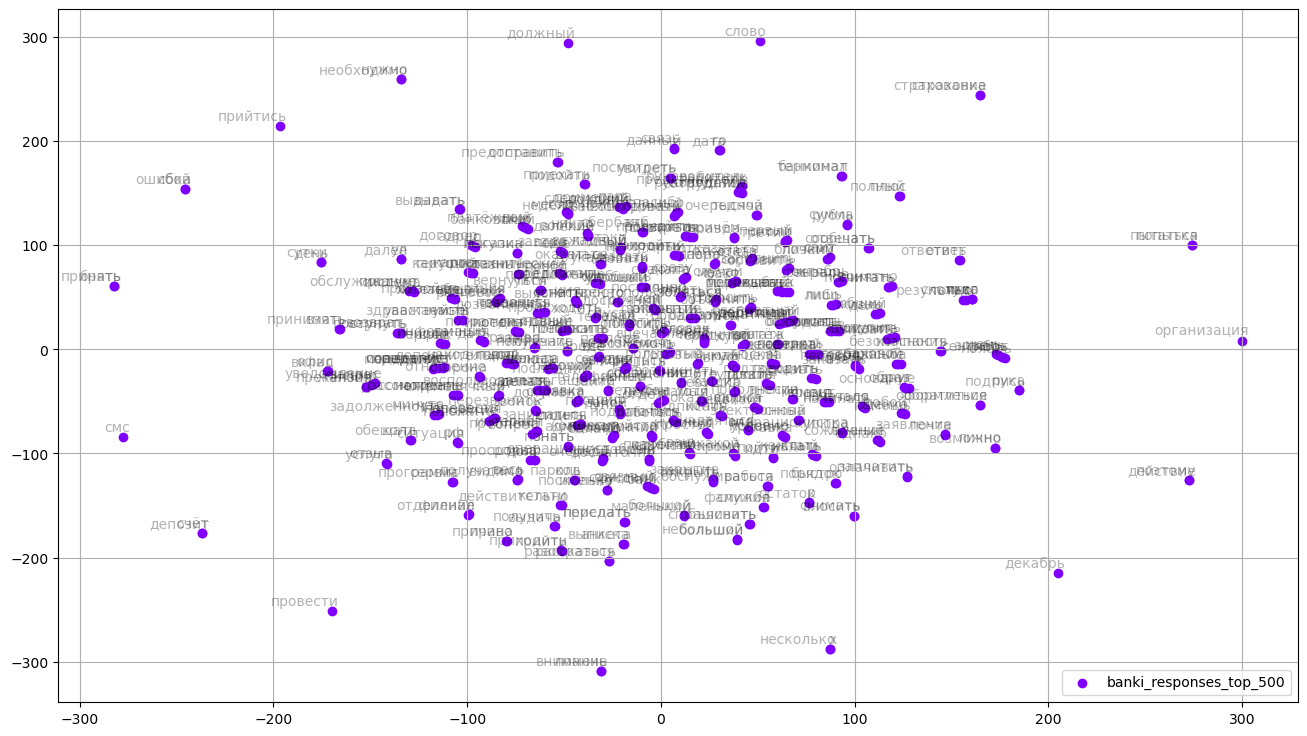

In [267]:
def tsne_plot(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 0, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label) 
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot('banki_responses_top_500', embeddings, words)

### Часть 2. Распространение метки
Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8 негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. `graphlab.label_propagation` (`graphlab` доступен бесплатно по образовательной лицензии)
2. `sklearn.semi_supervised.LabelPropagation`
3. `sklearn.semi_supervised.LabelSpreading`

In [ ]:
# пример построения графа 

import igraph as ig
g = ig.Graph(directed=True)
for word in model.wv.vocab.keys():
    g.add_vertex(word)
    
    
    
for word in model.wv.vocab.keys() :
    node = g.vs.select(name = word).indices[0]
    similar_words = model.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)